In [95]:
from matplotlib.pyplot import   subplots, loglog
from matplotlib import ticker
from numpy import zeros, sqrt, arange, cumsum, exp,  tile, mean, insert, power, ones, asarray
from numpy.random import randn as Normal, seed
import numpy as np
import numpy.matlib

# Brownian Motion

The Wiener process $W_t$ is a random process over $[0,T]$, i.e. a random variable indexed by a continuous index $t \in [0,T]$ that satisfies three conditions:

1. $W_t=0$. 
2. For $0 \leq s < t \leq T$ the random variable $W_t - W_s \sim \operatorname{N}(0, t-s)$.
3. $0 \leq s < t < u <v \leq T$ the random variables $W_t - W_s$, $W_v - W_u$ are independent.

We sample $W_t$ discretely, i.e. at times $t_j = j\cdot \delta t$ where $\delta t = T/N$ for some $N$. Conditions (2) and (3) imply that 
\begin{equation}
    W_j = W_{j-1} + \operatorname{d}W_j \label{eq:vector_ray}
\end{equation}
where $\operatorname{d}W_j \sim \sqrt{\delta t}\operatorname{N}(0,1)$.

In [3]:
T, n = 1, 10000
dt = T/n
dW = zeros(n)
W = zeros(n)

seed(1)
dW[0] = sqrt(dt)*Normal()
W[1] = W[0] + dW[0]
for j in range(2, n):
    dW[j] = sqrt(dt)*Normal()
    W[j] = W[j-1] + dW[j]

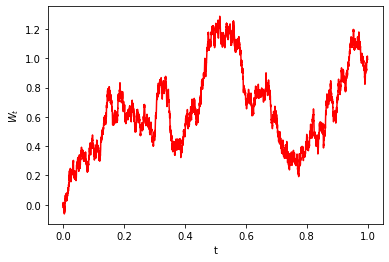

In [4]:
ts = arange(0, T, dt)
fig, ax = subplots()
ax.plot(ts, W, "r-")
ax.set_xlabel("t");
ax.set_ylabel("$W_t$");

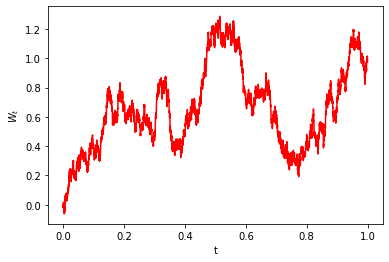

In [5]:
seed(1)
dW = sqrt(dt)*Normal(n)
W = cumsum(dW)
ax.clear()
ax.plot(ts, W, "r-")
ax.set_xlabel("t");
ax.set_ylabel("$W_t$");
fig

$U_t = \exp\left(t + \frac{1}{2} W_t\right)$

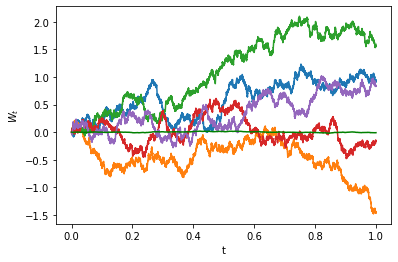

In [6]:
n_paths = 1000
dW = sqrt(dt)*Normal(n_paths,n)
W = cumsum(dW, axis=1)
w = mean(W, axis=0)
ax.clear()
for i in range(5):
    ax.plot(ts, W[i])
ax.plot(ts, w, "g")
ax.set_xlabel("t");
ax.set_ylabel("$W_t$");
fig

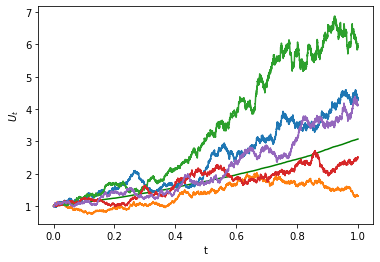

In [7]:
ax.clear()
U = exp(tile(ts, (n_paths,1)) + 0.5*W)
u = mean(U, axis=0)
ax.plot(ts, u, "g")
for i in range(5):
    ax.plot(ts, U[i])
ax.set_xlabel("t");
ax.set_ylabel("$U_t$");
fig

# Stochastic Integrals

A Riemann integral $\int_0^T h(t)dt$ is approximated by the Riemann sum

\begin{equation}
    \sum_{j=0}^{N-1} h(t_j) \left( t_{j+1} -t_j \right)
    \label{eq:vector_ray1}
\end{equation}

By analogy 

\begin{equation}
    \sum_{j=0}^{N-1} h(t_j) \left( W_{t_{j+1}} - W_{t_j} \right)
\end{equation}

can be considered an approximation of the stochastic integral $\int_0^T h(t) dW_t$.
This is called the Ito integral of $h$.

Below we approximate $\int_0^T h(t) dW_t$ where $h(t) = W_t$


In [8]:
dW = sqrt(dt) * Normal(n)

W = cumsum(dW)

ito_integral = sum(insert(W[:-1], 0, 0) * dW)
print(ito_integral)

-0.22965619310099722


Note that $h$ is evaluated at the beginning of the interval $[t_j, t_{j+1}]$. Evaluating $h$ at 
$
\frac{t_j + t_{j+1}}{2}
$
defines the Stratonovich integral. In the case where $h = W$ the difficulty is that $W$ isn't sampled at $(t_j + t_{j+1})/2$. Fortunately it can be shown that 

\begin{equation}
    \frac{W_{t+1} + W_{t}}{2} + \operatorname{N}(0, \delta t /4)
\end{equation}

is a Brownian motion. The Stratonovich integral markedly differs from the Ito integral and the difference does not disappear as $\delta t \rightarrow 0$.

In [9]:
strat_integral = sum(
    (
        .5*(W + insert(W[:-1], 0, 0)) + .5*sqrt(dt)*Normal(n)
    )*dW
)
print(strat_integral)

0.27436789666581207


It's possible to evaluate both of these integrals analytically: for example the Ito intergal
\begin{align}
    \sum_{j=0}^{N-1} W_{t_j} \left( W_{t_{j+1}} - W_{t_j} \right) &= \frac{1}{2}\sum_{j=0}^{N-1} \left( W_{t_{j+1}}^2 - W_{t_j}^2  - \left( W_{t_{j+1}} - W_{t_j} \right)^2 \right) \\
    &= \frac{1}{2} \left ( W_{T}^2 - W_{0}^2  -  \sum_{j=0}^{N-1} \left( W_{t_{j+1}} - W_{t_j} \right)^2 \right) \\
\end{align}
The sum term can be shown to have expected value $T$ and variance $\operatorname{O}(\delta t)$. Hence as $\delta t \rightarrow 0$

\begin{equation}
    \int_0^T W_t dW_t \rightarrow \frac{1}{2} W_T^2 - \frac{1}{2} T
\end{equation}


In [10]:
ito_integral_err = ito_integral - (0.5 * W[-1]**2 - 0.5*T)
ito_integral_err

-0.00039832781499010705

The Stratonovich integral on the other hand 


\begin{equation}
    \int_0^T W_t dW_t \rightarrow \frac{1}{2} W_T^2
\end{equation}

In [11]:

strat_integral_err = strat_integral - 0.5 * W[-1]**2
strat_integral_err



0.003625761951819184

# Euler-Maruyama Method

A scalar time invariant SDE in integral form can be written

\begin{equation}
    X_t = X_0 + \int_0^t f(X_s)ds + \int_0^t g(X_s) dW_s
\end{equation}

Here $f,g$ are conventional functions, $X_0$ is a random variable, and the second integral is interpreted as an Ito integral.

The integral equation can be written in differential form

\begin{equation}
    dX_t = f(X_t)dt + g(X_t)dW_t,\, X_0 = X
\end{equation}

for some random variable $X$.

Let $\Delta t = T/N$ and $\tau_j = j\cdot \Delta t$. Then Euler-Maruyama (EM) method takes the form

\begin{equation}
    X_{\tau_j} - X_{\tau_{j-1}} = f \left(X_{\tau_{j-1}} \right) \cdot \Delta t + g \left(X_{\tau_{j-1}} \right) \cdot \left( W_{\tau_j} - W_{\tau_{j-1}}\right)
\end{equation}

We use EM to solve the linear SDE

\begin{equation}
    dX_t = \lambda X_t dt = \mu X_t dW_t, \, X_0 = X
\end{equation}

i.e., $f(X) = \lambda X$ and $g(X) = \mu X$.

Note that Black-Scholes can be derived from this SDE and has the analytical solution

\begin{equation}
    X_t = X_0 \exp\left\{\left( \lambda - \frac{1}{2}\mu^2\right)t + \mu W_t\right\}
\end{equation}

Note that 

\begin{equation}
\left( W_{\tau_j} - W_{\tau_{j-1}}\right) = W_{jR\delta t} - W_{(j-1)R\delta t} = \sum_{k=jR -R +1}^{jR} dW_k
\end{equation}

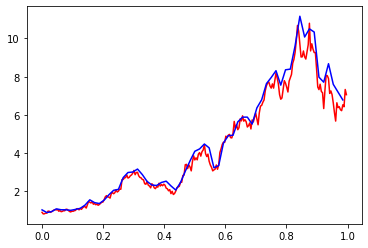

In [12]:
lamb = 2
mu = 1
X_zero = 1
T = 1
N = 2**8
dt = 1/N
dts = arange(0, T, dt)
dW = sqrt(dt) * Normal(N)
W = cumsum(dW)

X_anal = X_zero * exp((lamb - 0.5*mu**2)*dts + mu*W)
ax.clear()
ax.plot(dts, X_anal, color="r")

R = 4
Dt = R*dt 
Dts = arange(0, T, Dt)

L = N//R 
X_em = zeros(L)
X_temp = X_zero
for j in range(L):
    W_inc = sum(dW[R*(j-1):R*j])
    X_temp += Dt * lamb*X_temp + mu*X_temp*W_inc
    X_em[j] = X_temp

ax.plot(Dts, X_em.T, color="b")
fig

# Strong and Weak Convergence of EM Method 

As $\Delta t \rightarrow 0$ convergence seems to take place but in what sense? If there exists $C$ such that

\begin{equation}
    \mathbb{E} \left| X_n - X_\tau \right| \leq C (\Delta t)^\gamma
\end{equation}

for all $\tau = n \Delta t \in \left[ 0,T \right]$ then the method is said to have *strong order of convergence* equal to $\gamma$.
If $f,g$ satisfy appropriate conditions then EM can be shown to have strong order of convergence $\frac{1}{2}$.

We're particularly interested in agreement at the endpoint $t = T$, so define endpoint error

\begin{equation}
    e_{\Delta t}^{\text{strong}} := \mathbb{E} \left| X_L - X_T  \right| \quad \text{where} \quad L \Delta t = T
\end{equation}

Note that if the strong convergence bound holds for all $\tau$ then it holds for $L$. Therefore 

\begin{equation}
    e_{\Delta t}^{\text{strong}}  \leq C \sqrt{\Delta t}
\end{equation}

We now investigate the strong convergence of EM by trying 5 different step-sizes $\Delta t = 2^{p-1}\delta t$ for $1 \leq p \leq 5$.

In [13]:
lamb = 2; mu = 1; X_zero = 1; 
T = 1; N = 2**9; dt = T/N; 
M = 1000
X_err = zeros((M, 5))

for s in range(M):
    dW = sqrt(dt) * Normal(N)
    W = cumsum(dW)
    X_true = X_zero * exp((lamb - 0.5*mu**2) + mu*W[-1])
    for p in range(5):
        R = 2**p; Dt = R*dt; L = N//R
        X_temp = X_zero
        for j in range(L):
            W_inc = sum(dW[R*(j-1):R*j])
            X_temp += Dt*lamb*X_temp + mu*X_temp*W_inc
        X_err[s, p] = abs(X_temp - X_true)

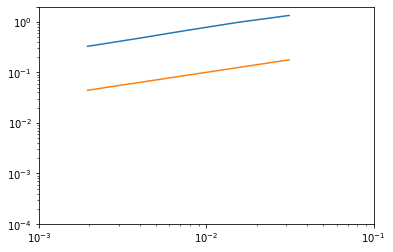

In [14]:
Dts = dt * power(2, [0,1,2,3,4])
ax.clear()
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim([1e-3, 1e-1])
ax.set_xticks([1e-3,1e-2, 1e-1])
ax.set_ylim([1e-1, 1])
ax.set_yticks([1e-4,1e-3, 1e-2, 1e-1, 1,2])

ax.plot(Dts, X_err.mean(axis=0))
ax.plot(Dts, Dts**(0.5))
# ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
fig

There are three sources of error 
    
1. Sampling error: error arrising from approximation $\mathbb{E}$ by sampled mean.
2. Random number bias: errors in the RNG.
3. Rounding error: floating point errors.

Typically sampling error is the chief source of errors: the sampling error decays like $1/\sqrt{M}$ where $M$ is the number of sample paths. But as $\Delta t \rightarrow 0$, lack of independence in the samples from the RNG start to matter.

Although the definition of strong convergence involves an $E$ it has implications for individual simulations: the Markov inequality
\begin{equation}
    \mathbb{P}\left( |X| \geq a \right) \leq \frac{\mathbb{E}|X|}{a}
\end{equation}

Hence, taking $a = (\Delta t)^{1/4}$ we have that 
\begin{equation}
    \mathbb{P}\left( |X_n - X_{\tau}| \geq (\Delta t)^{1/4}  \right) \leq C (\Delta t)^{1/4}
\end{equation}

or

\begin{equation}
    \mathbb{P}\left( |X_n - X_{\tau}| < (\Delta t)^{1/4}  \right) \geq 1 - C (\Delta t)^{1/4}
\end{equation}

This shows that the error at a fixed point $t\in [0,T]$ is small with probability close to 1. 

The strong order of convergence measures the rate at which the "mean of the error" decays as $\Delta t \rightarrow 0$. A less stringent measure is the "error of the means", i.e., *weak order of convergence* equal to $\gamma$:
\begin{equation}
    | \mathbb{E}\left[ p(X_n) \right] -\mathbb{E}\left[ p(X_n) \right] | \leq C (\Delta t)^{\gamma}
\end{equation}

for all functions $p$ in some class, for all $\tau = n \Delta t \in [0,T]$ and $\Delta t$ sufficiently small. Typically functions $p$ satisfy smoothness and polynomial growth conditions. Letting $p = I$ we show that EM has weak order of convergence $\gamma = 1$ and
\begin{equation}
    e_{\Delta t}^{\text{weak}} := \left| \mathbb{E}\left[ X_L \right] - \mathbb{E}\left[ X_T \right]\right| \text{ where } L\Delta t = T
\end{equation}
the weak enpoint error in EM. Then we have 
\begin{equation}
    e_{\Delta t}^{\text{weak}} \leq C \Delta t
\end{equation}


In [56]:
lam = 2; mu = 0.1; Xzero = 1; T = 1; M = 50000
Xem = zeros(5)
for p in range(5):
    Dt = 2**(p-9); L = int(T//Dt)
    Xtemp = Xzero*ones(M)
    for j in range(1,L+1):
        Winc = sqrt(Dt)*Normal(M)
        Xtemp = Xtemp + Dt*lam*Xtemp + mu*Xtemp*Winc
    Xem[p] = mean(Xtemp, axis=0)
Xerr = abs(Xem - exp(lam))

[8.37137528 7.30920226 7.17900531 ... 7.26299305 7.39665705 7.35718906]
[6.67140341 6.64755344 8.56921362 ... 6.36656425 6.28508763 7.90642439]
[7.32525694 8.06567471 6.63569595 ... 6.42344712 7.65212642 7.07388892]
[6.82042171 7.38054574 8.12495475 ... 7.49327439 8.21406345 7.44431379]
[6.01424643 6.41347574 7.06633637 ... 6.60266166 7.49865193 6.47342327]


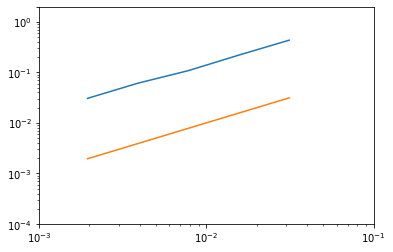

In [77]:
Dts = power(2, 9-asarray([0,1,2,3,4]))
Dts = 1/Dts
ax.clear()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1e-3, 1e-1])
ax.set_xticks([1e-3,1e-2, 1e-1])
ax.set_ylim([1e-1, 1])
ax.set_yticks([1e-4,1e-3, 1e-2, 1e-1, 1,2])
ax.plot(Dts, Xerr)
ax.plot(Dts, Dts)
fig

It's the case that $\mathbb{E}\left[ X_T \right] = e^{\lambda T}$

Note that we use different paths for each step-size $\Delta t$; weak convergence concerns only the mean of the solution and so we are free to use any $\sqrt{\Delta t}\operatorname{N}(0,1)$ sample for the increment $W_{\tau_j}-W_{\tau_{j-1}}$ on any step. In fact the order of convergence is maintained if the increment is replaced by independent draws from $\sqrt{\Delta t}V_j$ where $V_j \sim \operatorname{Bernoulli}(-1,1)$. Making this replacement is called the *weak* Euler-Maruyama method (and it still has weak order of convergence $\gamma = 1$.

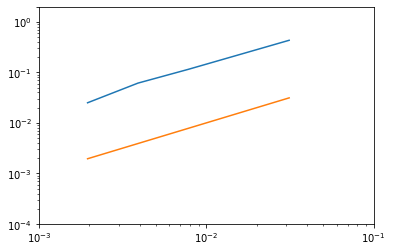

In [79]:
lam = 2; mu = 0.1; Xzero = 1; T = 1; M = 50000
Xem = zeros(5)
for p in range(5):
    Dt = 2**(p-9); L = int(T//Dt)
    Xtemp = Xzero*ones(M)
    for j in range(1,L+1):
        Winc = sqrt(Dt)*np.random.choice([-1,1], M, p=[0.5, 0.5])
        Xtemp = Xtemp + Dt*lam*Xtemp + mu*Xtemp*Winc
    Xem[p] = mean(Xtemp, axis=0)
Xerr = abs(Xem - exp(lam))
Dts = power(2, 9-asarray([0,1,2,3,4]))
Dts = 1/Dts
ax.clear()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1e-3, 1e-1])
ax.set_xticks([1e-3,1e-2, 1e-1])
ax.set_ylim([1e-1, 1])
ax.set_yticks([1e-4,1e-3, 1e-2, 1e-1, 1,2])
ax.plot(Dts, Xerr)
ax.plot(Dts, Dts)
fig

# Milstein's Higher Order Method

Milstein's method adds a correction inspired by the Ito-Taylor expansion:

\begin{multline}
X_j = X_{j-1} +\Delta t f(X_{j-1}) + g(X_{j-1})\left( W(\tau_j) - W(\tau_{j-1})\right) +\\ \frac{1}{2} g(X_{j-1})g'(X_{j-1})\left( \left( W(\tau_j) - W(\tau_{j-1})\right) - \Delta t \right)
\end{multline}

We apply Milstein's method to 

\begin{equation}
    dX_t = rX_t (K-X_t)dt + \beta X_t dW_t
\end{equation}

In [105]:
r = 2; K = 1; beta = 0.25; Xzero = 0.5
T = 1; N = 2**11; dt = T/N; M = 500
RR = np.asarray([1, 16, 32, 64, 128])
dW = sqrt(dt)*Normal(M, N)
Xmil = zeros((M,5))
for i,R in enumerate(RR):
    Dt = R*dt; L = N//R
    Xtemp = Xzero*ones(M)
    for j in range(0,L):
        Winc = np.sum(dW[:, R*j:R*(j+1)], axis=1)
        Xtemp *= 1+Dt*r*(K-Xtemp)+beta*Winc+0.5*(beta**2)*(Winc**2-Dt)
    Xmil[:,i] = Xtemp
Xref = Xmil[:,0]
Xref.shape
Xmil[:,1:].shape
Xerr = np.abs(Xmil[:,1:] - np.transpose(numpy.matlib.repmat(Xref,4,1)));
Dtvals = dt*RR[1:]

array([0.0078125, 0.015625 , 0.03125  , 0.0625   ])

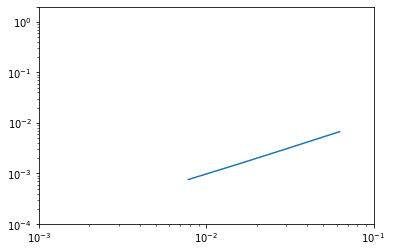

In [107]:
ax.clear()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1e-3, 1e-1])
ax.set_xticks([1e-3,1e-2, 1e-1])
ax.set_ylim([1e-1, 1])
ax.set_yticks([1e-4,1e-3, 1e-2, 1e-1, 1,2])
ax.plot(Dtvals, np.mean(Xerr, axis=0))
fig